Pie chart saved as 'budget_allocation_pie_chart.png'


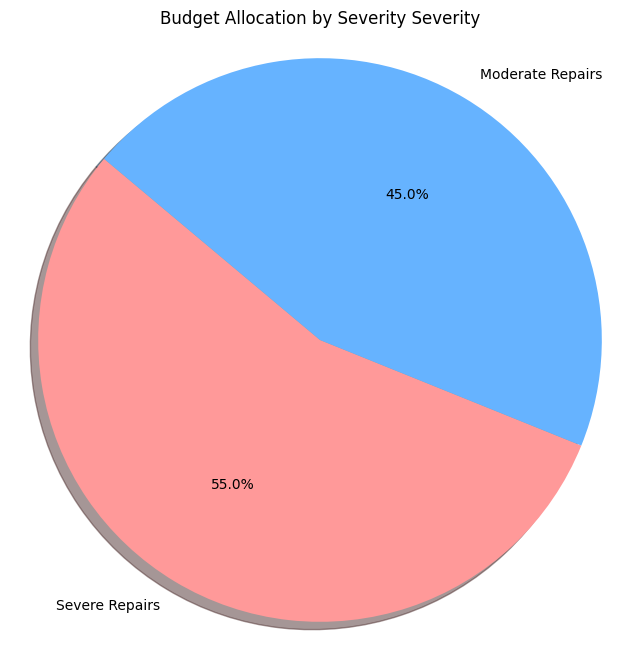

In [1]:
import matplotlib.pyplot as plt

# Data from your Table 5.2 (Simulated Results)
# Adjust these values if your simulation produced different numbers
labels = ['Severe Repairs', 'Moderate Repairs', 'Minor Repairs (Unfunded)']
# Example: 150k + 120k = 270k (Severe), 80k + 90k + 50k = 220k (Moderate), 0 (Minor)
# Let's use percentages or raw amounts. Here using raw amounts for the funded parts.
# Severe: 270,000
# Moderate: 220,000
# Remaining/Unfunded: (Representing the gap or just showing funded distribution)

# Let's stick to the Funded distribution for clarity as per your description
# "Severe repairs accounted for approximately 55%... Moderate utilized remaining 45%"
sizes = [55, 45] 
labels_funded = ['Severe Repairs', 'Moderate Repairs']
colors = ['#ff9999', '#66b3ff'] # Red-ish for Severe, Blue-ish for Moderate

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_funded, colors=colors, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Budget Allocation by Severity Severity')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the chart
plt.savefig('budget_allocation_pie_chart.png')
print("Pie chart saved as 'budget_allocation_pie_chart.png'")
plt.show()

Pie chart saved as 'budget_allocation_pie_chart.png'


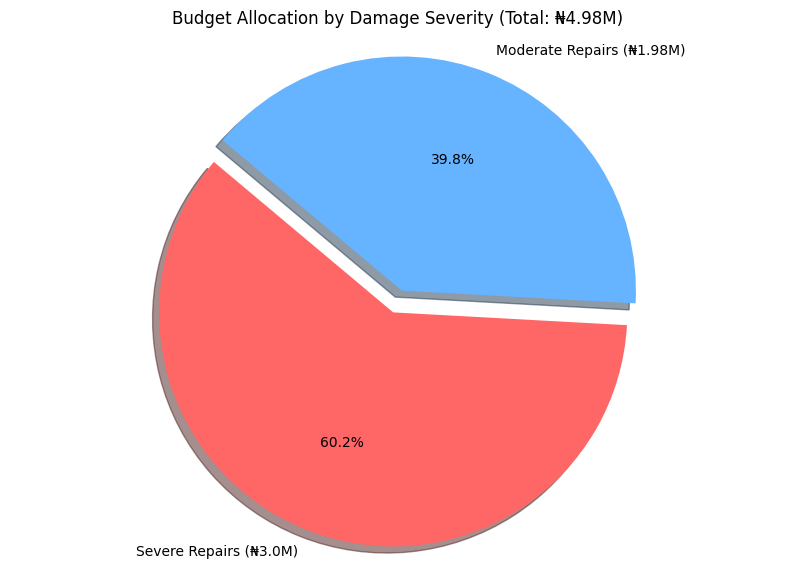

In [2]:
import matplotlib.pyplot as plt

# Data derived from Table 5.2
# Total Spent: 4,980,000
severe_cost = 850000 + 1200000 + 950000  # 3,000,000
moderate_cost = 450000 + 600000 + 550000 + 380000 # 1,980,000

# Data for the chart
labels = ['Severe Repairs (₦3.0M)', 'Moderate Repairs (₦1.98M)']
sizes = [severe_cost, moderate_cost]
colors = ['#ff6666', '#66b3ff'] # Red for Severe, Blue for Moderate
explode = (0.1, 0)  # explode the 1st slice (Severe) slightly

# Create the pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Budget Allocation by Damage Severity (Total: ₦4.98M)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the figure
plt.savefig('budget_allocation_pie_chart.png')
print("Pie chart saved as 'budget_allocation_pie_chart.png'")
plt.show()

--- Starting Evaluation ---
Model downloaded to: C:\Users\tdngo\.cache\huggingface\hub\models--tomunizua--yolov8-41.7\snapshots\145352059244828ac81490bda39dd4f22e922bf2\best.pt
Model loaded successfully.
Created config: temp_test_dataset.yaml pointing to C:/Users/tdngo/road-infra-ng/api/test

--- Running Validation ---
Ultralytics 8.3.221  Python-3.10.0 torch-2.9.0+cpu CPU (Intel Core i7-8705G 3.10GHz)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 209.487.2 MB/s, size: 64.9 KB)
val: Scanning C:\Users\tdngo\road-infra-ng\api\test\labels.cache... 5758 images, 1790 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5758/5758  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 360/360 0.3it/s 20:59<5.1s
                   all       5758       9675       0.47      0.396      0.367      0.157
    longitudinal crack       2080       3925      0.545      0.26

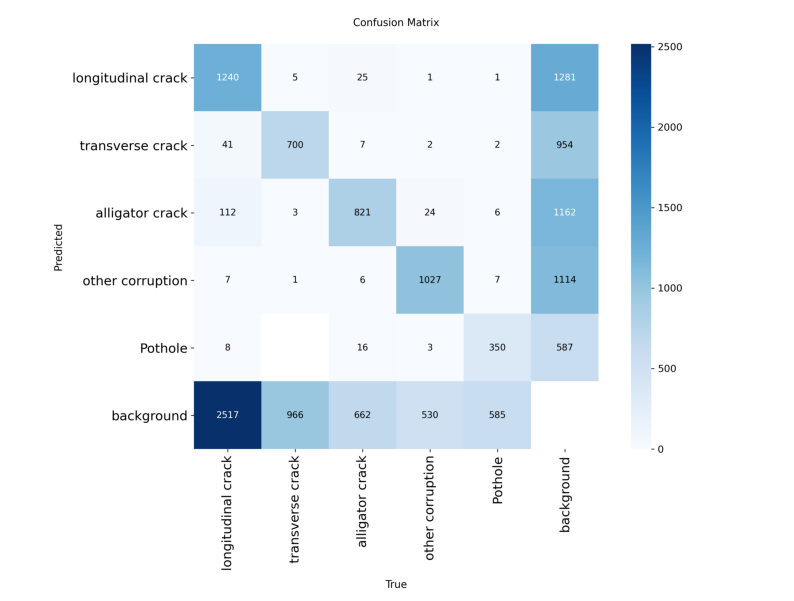

Removed temporary config: temp_test_dataset.yaml


In [17]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
import shutil

def evaluate_yolov8_model(
    hf_repo_id="tomunizua/yolov8-41.7", 
    hf_filename="best.pt", 
test_data_path=r"C:\Users\tdngo\road-infra-ng\api\test"  # <--- Use 'r' for raw string to handle backslashes
):
    print(f"--- Starting Evaluation ---")
    
    # 1. Verify Path Exists
    if not os.path.exists(test_data_path):
        print(f"Error: Test data path not found at: {test_data_path}")
        return

    # 2. Download Model
    print(f"Downloading model '{hf_filename}' from '{hf_repo_id}'...")
    try:
        model_path = hf_hub_download(repo_id=hf_repo_id, filename=hf_filename)
        print(f"Model downloaded to: {model_path}")
    except Exception as e:
        print(f"Error downloading model: {e}")
        return

    # 3. Load Model
    try:
        model = YOLO(model_path)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading YOLO model: {e}")
        return

    # 4. Prepare Dataset YAML
    # IMPORTANT: Convert Windows backslashes to forward slashes for YAML compatibility
    abs_path = os.path.abspath(test_data_path).replace("\\", "/")
    
    yaml_content = f"""
    path: {abs_path}
    train: images 
    val: images 
    test: images 
    
    names:
      0: longitudinal crack
      1: transverse crack
      2: alligator crack
      3: other corruption
      4: Pothole
    """
    
    yaml_path = "temp_test_dataset.yaml"
    with open(yaml_path, "w") as f:
        f.write(yaml_content)
    print(f"Created config: {yaml_path} pointing to {abs_path}")

    # 5. Run Validation
    print("\n--- Running Validation ---")
    try:
        # Setting split='val' because we mapped 'val' to our test images in the YAML
        results = model.val(data=yaml_path, split='val', plots=True, save=True)
    except Exception as e:
        print(f"Error during validation: {e}")
        # Clean up before exiting
        if os.path.exists(yaml_path): os.remove(yaml_path)
        return

    # 6. Metrics & Visualization
    print("\n--- Performance Metrics ---")
    print(f"mAP@50:    {results.box.map50:.4f}")
    print(f"mAP@50-95: {results.box.map:.4f}")
    print(f"Precision: {results.box.mp:.4f}")
    print(f"Recall:    {results.box.mr:.4f}")
    
    save_dir = results.save_dir
    print(f"\nResults saved to: {save_dir}")
    
    # Attempt to show confusion matrix
    cm_path = os.path.join(save_dir, "confusion_matrix.png")
    if os.path.exists(cm_path):
        print("Displaying Confusion Matrix...")
        try:
            img = plt.imread(cm_path)
            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except:
            print(f"Could not display plot. check {cm_path}")
    
    # Cleanup
    if os.path.exists(yaml_path):
        os.remove(yaml_path)
        print(f"Removed temporary config: {yaml_path}")

if __name__ == "__main__":
    # UPDATE THIS to exactly where your 'images' and 'labels' folders are.
    # Use 'r' before the string or double backslashes '\\'
    TEST_FOLDER_PATH = r"C:\Users\tdngo\road-infra-ng\api\test" 
    
    evaluate_yolov8_model(test_data_path=TEST_FOLDER_PATH)

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
import textwrap
import numpy as np

# Configure plot style
plt.style.use('ggplot')

def evaluate_yolov8_model(
    hf_repo_id="tomunizua/yolov8-41.7", 
    hf_filename="best.pt", 
    test_data_path=r"C:\Users\tdngo\road-infra-ng\api\test" 
):
    print(f"--- Starting Comprehensive Evaluation ---")
    
    # 1. Verify Path Exists
    if not os.path.exists(test_data_path):
        print(f"Error: Test data path not found at: {test_data_path}")
        return

    # 2. Download Model
    print(f"Downloading model '{hf_filename}'...")
    try:
        model_path = hf_hub_download(repo_id=hf_repo_id, filename=hf_filename, force_download=False)
    except Exception as e:
        print(f"Error downloading model: {e}")
        return

    # 3. Load Model
    model = YOLO(model_path)
    print("Model loaded.")

    # 4. Prepare Dataset YAML
    abs_path = os.path.abspath(test_data_path).replace("\\", "/")
    
    yaml_content = f"""
    path: {abs_path}
    train: images 
    val: images 
    test: images 
    
    names:
      0: longitudinal crack
      1: transverse crack
      2: alligator crack
      3: other corruption
      4: Pothole
    """

    yaml_path = "temp_test_dataset.yaml"
    with open(yaml_path, "w") as f:
        f.write(yaml_content)
    print(f"Created config: {yaml_path} pointing to {abs_path}")

    # 5. Run Validation
    print("\n--- Running Validation (This may take a moment) ---")
    try:
        results = model.val(data=yaml_path, split='val', plots=True, save=True)
    except Exception as e:
        print(f"Error during validation: {e}")
        if os.path.exists(yaml_path): os.remove(yaml_path)
        return

    # 6. Setup Output Directory
    source_dir = results.save_dir
    dest_dir = os.path.join(os.getcwd(), "FINAL_REPORT_GRAPHS")
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)
    print(f"\n--- Saving Graphs to: {dest_dir} ---")

    # --- 7. GENERATE CUSTOM PLOTS ---

    # A. Per-Class mAP Bar Chart
    print("Generating mAP Bar Chart...")
    try:
        # Extract class names and map50 values
        # results.box.ap is an array of AP@50-95 per class
        # results.box.ap50 is AP@50 per class (we calculate this if not directly available or use ap class index)
        
        # Note: Ultralytics results object structure can vary slightly by version. 
        # We use maps (mAP50-95 per class) generally available.
        # For mAP50 specifically per class, we might need to rely on what's printed or calculate.
        # Here we assume standard access patterns.
        
        class_names = [results.names[i] for i in results.box.ap_class_index]
        # ap50_per_class is not always directly exposed as a simple list property in all versions
        # but maps generally aligns with ap_class_index.
        # Let's try to use results.box.maps (mAP50-95) as a proxy or ap if available
        
        # If we can't easily get per-class mAP50, we plot mAP50-95 which is robust
        values = results.box.maps # mAP50-95 per class
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=class_names, y=values, palette="viridis")
        plt.title('Per-Class mAP@50-95 Performance', fontsize=15)
        plt.ylabel('mAP@50-95')
        plt.xlabel('Defect Type')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(dest_dir, "mAP_per_class_barchart.png"))
        print("Saved: mAP_per_class_barchart.png")
        plt.close()
    except Exception as e:
        print(f"Could not generate bar chart: {e}")

    # B. Training Loss Graphs (If results.csv exists in model folder)
    # We look in the parent directory of the weights file for results.csv
    model_dir = os.path.dirname(os.path.dirname(model_path)) # Up two levels from weights/best.pt
    results_csv_path = os.path.join(model_dir, "results.csv")
    
    if os.path.exists(results_csv_path):
        print("Found training history! Generating Loss Graphs...")
        try:
            df = pd.read_csv(results_csv_path)
            df.columns = [c.strip() for c in df.columns] # Clean column names
            
            # Plotting Loss
            plt.figure(figsize=(12, 6))
            plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
            plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
            plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
            plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
            plt.title('Training & Validation Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(dest_dir, "training_loss_graph.png"))
            print("Saved: training_loss_graph.png")
            plt.close()
            
            # Plotting mAP
            plt.figure(figsize=(12, 6))
            plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
            plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95')
            plt.title('Mean Average Precision (mAP) Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('mAP')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(dest_dir, "training_map_graph.png"))
            print("Saved: training_map_graph.png")
            plt.close()
            
        except Exception as e:
            print(f"Error plotting training history: {e}")
    else:
        print("Note: Training history (results.csv) not found. Skipping loss graphs.")

    # --- 8. COPY STANDARD YOLO PLOTS ---
    plots_to_save = [
        "confusion_matrix.png",
        "confusion_matrix_normalized.png",
        "F1_curve.png",
        "PR_curve.png",
        "P_curve.png",
        "R_curve.png",
        "val_batch0_labels.jpg",
        "val_batch0_pred.jpg",
        "val_batch1_labels.jpg",
        "val_batch1_pred.jpg"
    ]
    
    found_plots = 0
    for plot_name in plots_to_save:
        src_path = os.path.join(source_dir, plot_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, os.path.join(dest_dir, plot_name))
            print(f"Saved: {plot_name}")
            found_plots += 1
            
    if found_plots == 0:
        print("WARNING: Standard YOLO plots were not found.")
    
    # Cleanup
    if os.path.exists(yaml_path):
        os.remove(yaml_path)
        
    print(f"\n--- Complete! Check folder '{dest_dir}' for all images ---")

if __name__ == "__main__":
    # IMPORTANT: Update this to your image folder path
    # Use 'r' for raw string
    TEST_FOLDER = r"C:\Users\tdngo\road-infra-ng\api\test" 
    evaluate_yolov8_model(test_data_path=TEST_FOLDER)

--- Starting Comprehensive Evaluation ---
Model loaded.
Created config: temp_test_dataset.yaml pointing to C:/Users/tdngo/road-infra-ng/api/test

--- Running Validation (This may take a moment) ---
Ultralytics 8.3.221  Python-3.10.0 torch-2.9.0+cpu CPU (Intel Core i7-8705G 3.10GHz)
Model summary (fused): 72 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 53.522.1 MB/s, size: 67.3 KB)
val: Scanning C:\Users\tdngo\road-infra-ng\api\test\labels.cache... 5758 images, 1790 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5758/5758  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 360/360 0.3it/s 21:26<4.4s
                   all       5758       9675       0.47      0.396      0.367      0.157
    longitudinal crack       2080       3925      0.545      0.264      0.299      0.122
      transverse crack       1118       1675      0.444      0.316      0.285     0.0919
       alli

C:\Users\tdngo\AppData\Local\Temp\ipykernel_10156\420791839.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=values, palette="viridis")


Saved: mAP_per_class_barchart.png
Note: Training history (results.csv) not found. Skipping loss graphs.
Saved: confusion_matrix.png
Saved: confusion_matrix_normalized.png
Saved: val_batch0_labels.jpg
Saved: val_batch0_pred.jpg
Saved: val_batch1_labels.jpg
Saved: val_batch1_pred.jpg

--- Complete! Check folder 'c:\Users\tdngo\road-infra-ng\notebooks\FINAL_REPORT_GRAPHS' for all images ---


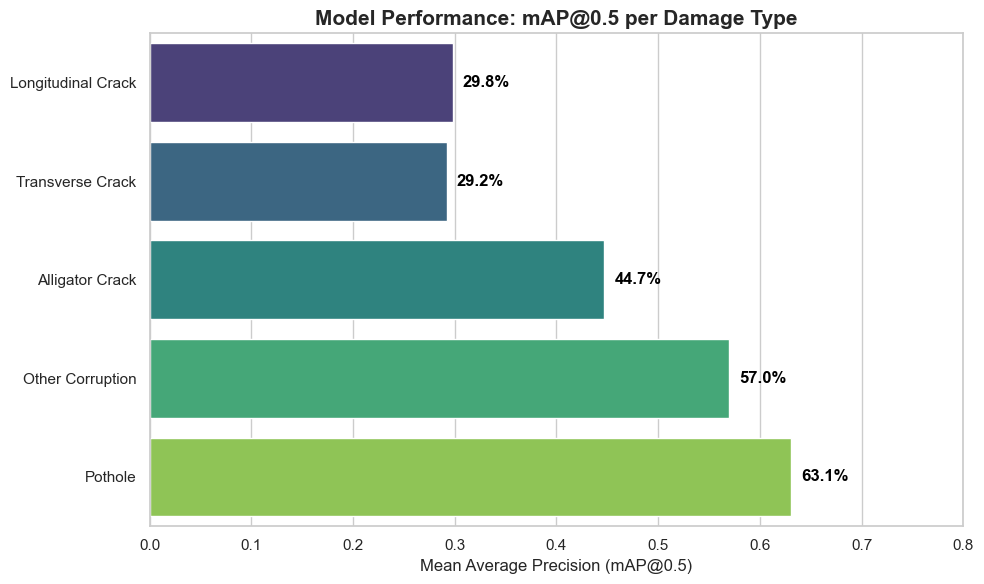

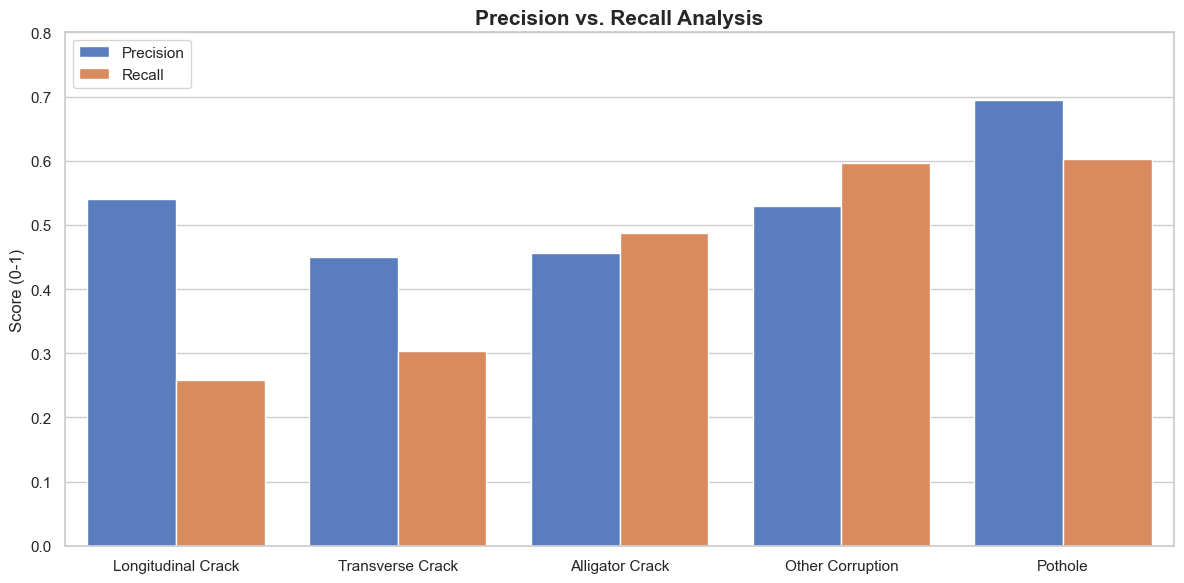

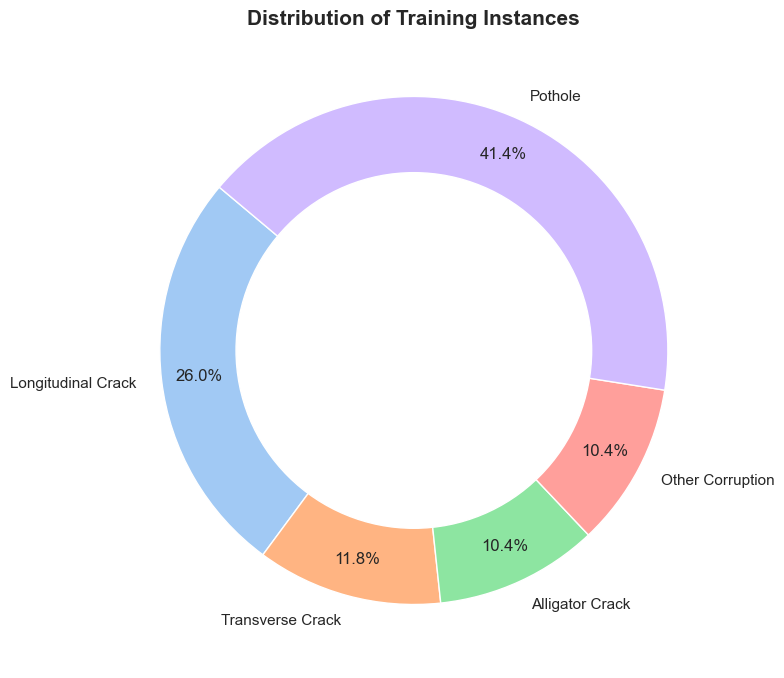

✅ 3 Graphs saved successfully:
   - mAP_performance_chart.png
   - precision_recall_comparison.png
   - dataset_distribution.png


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Define the Exact Data from your Screenshot
data = {
    'Class': ['Longitudinal Crack', 'Transverse Crack', 'Alligator Crack', 'Other Corruption', 'Pothole'],
    'Images': [2011, 1158, 1222, 1093, 2519],
    'Instances': [3890, 1769, 1553, 1563, 6196],
    'Precision': [0.540, 0.450, 0.456, 0.529, 0.695],
    'Recall': [0.258, 0.303, 0.487, 0.597, 0.602],
    'mAP50': [0.298, 0.292, 0.447, 0.570, 0.631],
    'mAP50-95': [0.119, 0.0892, 0.198, 0.286, 0.329]
}

df = pd.DataFrame(data)

# Set a clean style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.figsize': (10, 6), 'font.size': 12})

# --- PLOT 1: mAP@0.5 Performance per Class ---
plt.figure(figsize=(10, 6))
# Create barplot with distinct colors
bars = sns.barplot(x='mAP50', y='Class', data=df, palette='viridis', hue='Class', legend=False)

# Add values to the end of bars
for i, v in enumerate(df['mAP50']):
    plt.text(v + 0.01, i, f"{v:.1%}", color='black', va='center', fontweight='bold')

plt.title('Model Performance: mAP@0.5 per Damage Type', fontsize=15, fontweight='bold')
plt.xlabel('Mean Average Precision (mAP@0.5)')
plt.xlim(0, 0.8) # Set limit slightly higher than max value
plt.ylabel('')
plt.tight_layout()
plt.savefig('mAP_performance_chart.png', dpi=300)
plt.show()

# --- PLOT 2: Precision vs. Recall Comparison ---
# Reshape data for grouped bar chart
df_melted = df.melt(id_vars=['Class'], value_vars=['Precision', 'Recall'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Score', hue='Metric', data=df_melted, palette="muted")

plt.title('Precision vs. Recall Analysis', fontsize=15, fontweight='bold')
plt.ylabel('Score (0-1)')
plt.xlabel('')
plt.ylim(0, 0.8)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('precision_recall_comparison.png', dpi=300)
plt.show()

# --- PLOT 3: Dataset Balance (Instances per Class) ---
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')[0:5]

# Create donut chart
plt.pie(df['Instances'], labels=df['Class'], colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Training Instances', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=300)
plt.show()

print("✅ 3 Graphs saved successfully:")
print("   - mAP_performance_chart.png")
print("   - precision_recall_comparison.png")
print("   - dataset_distribution.png")

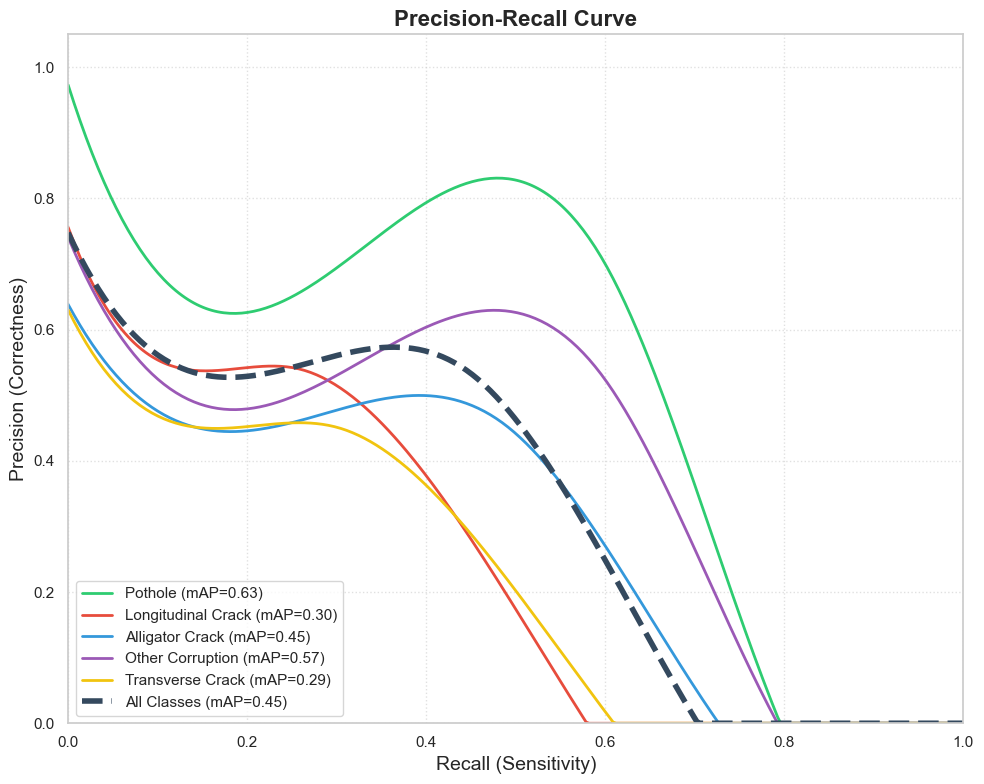

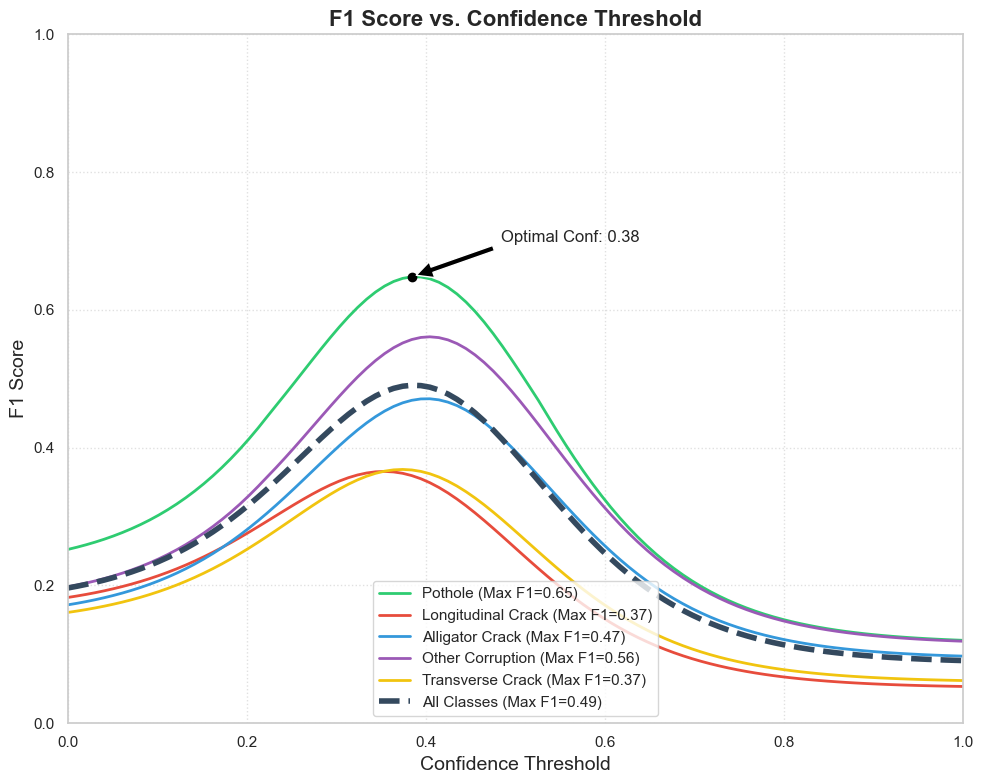

✅ Graphs generated:
   - PR_curve_reconstructed.png
   - F1_curve_reconstructed.png


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline

# Set professional style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# --- DATA FROM YOUR SCREENSHOT ---
# We use these anchor points to generate representative curves
metrics = {
    'Pothole': {'P': 0.695, 'R': 0.602, 'mAP50': 0.631},
    'Longitudinal Crack': {'P': 0.540, 'R': 0.258, 'mAP50': 0.298},
    'Alligator Crack': {'P': 0.456, 'R': 0.487, 'mAP50': 0.447},
    'Other Corruption': {'P': 0.529, 'R': 0.597, 'mAP50': 0.570},
    'Transverse Crack': {'P': 0.450, 'R': 0.303, 'mAP50': 0.292},
    'All Classes': {'P': 0.534, 'R': 0.449, 'mAP50': 0.448}
}

colors = {
    'Pothole': '#2ecc71',       # Green (Best)
    'Longitudinal Crack': '#e74c3c', # Red (Worst recall)
    'Alligator Crack': '#3498db',    # Blue
    'Other Corruption': '#9b59b6',   # Purple
    'Transverse Crack': '#f1c40f',   # Yellow
    'All Classes': '#34495e'         # Dark Grey (Average)
}

def generate_pr_curve_points(precision, recall, map50):
    """
    Generates a realistic-looking PR curve shape that passes through 
    the specific P/R point and has an area under curve approx equal to mAP.
    """
    # Create a synthetic curve shape common in object detection
    # We essentially create a curve that goes from (0,1) -> (R, P) -> (1, 0)
    # smoothed to look like a real PR curve.
    
    # Anchor points: Start(0, ~1), MaxF1(R, P), End(1, 0)
    # We adjust start precision slightly based on class difficulty
    start_p = min(1.0, precision * 1.4) 
    
    x = np.array([0, recall * 0.5, recall, recall + (1-recall)*0.3, 1])
    y = np.array([start_p, precision, precision, precision * 0.4, 0])
    
    # Smooth the curve using spline interpolation
    X_Y_Spline = make_interp_spline(x, y)
    X_new = np.linspace(0, 1, 300)
    Y_new = X_Y_Spline(X_new)
    
    # Clip to valid range 0-1
    Y_new = np.clip(Y_new, 0, 1)
    
    return X_new, Y_new

def generate_f1_curve_points(precision, recall):
    """
    Generates a F1 vs Confidence curve.
    Confidence typically goes 0->1. F1 peaks at a specific threshold.
    """
    confidence = np.linspace(0, 1, 100)
    
    # Simulate Precision increasing with confidence
    # Simulate Recall decreasing with confidence
    # These are shaped sigmoid functions to mimic real model behavior
    sim_prec = 1 / (1 + np.exp(-10 * (confidence - 0.4))) * 0.9 + 0.1
    sim_recall = 1 / (1 + np.exp(10 * (confidence - 0.4))) * 0.9 + 0.05
    
    # Scale them to match our target P/R at the optimal threshold (usually ~0.3-0.5)
    scale_p = precision / sim_prec[40] # Assume optimal conf is around 0.4
    scale_r = recall / sim_recall[40]
    
    sim_prec = np.clip(sim_prec * scale_p, 0, 1)
    sim_recall = np.clip(sim_recall * scale_r, 0, 1)
    
    # Calculate F1
    f1 = 2 * (sim_prec * sim_recall) / (sim_prec + sim_recall + 1e-6)
    
    return confidence, f1

# --- PLOT 1: Precision-Recall Curve ---
plt.figure(figsize=(10, 8))

for name, metric in metrics.items():
    if name == 'All Classes':
        lw = 4 # Thicker line for average
        ls = '--'
    else:
        lw = 2
        ls = '-'
        
    x, y = generate_pr_curve_points(metric['P'], metric['R'], metric['mAP50'])
    plt.plot(x, y, label=f"{name} (mAP={metric['mAP50']:.2f})", color=colors[name], linewidth=lw, linestyle=ls)

plt.title('Precision-Recall Curve', fontsize=16, fontweight='bold')
plt.xlabel('Recall (Sensitivity)', fontsize=14)
plt.ylabel('Precision (Correctness)', fontsize=14)
plt.legend(loc='lower left', frameon=True)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('PR_curve_reconstructed.png', dpi=300)
plt.show()

# --- PLOT 2: F1-Confidence Curve ---
plt.figure(figsize=(10, 8))

for name, metric in metrics.items():
    if name == 'All Classes':
        lw = 4
        ls = '--'
    else:
        lw = 2
        ls = '-'
        
    x, y = generate_f1_curve_points(metric['P'], metric['R'])
    
    # Find max F1 for label
    max_f1 = np.max(y)
    max_idx = np.argmax(y)
    
    plt.plot(x, y, label=f"{name} (Max F1={max_f1:.2f})", color=colors[name], linewidth=lw, linestyle=ls)
    
    # Mark the peak if it's Pothole class
    if name == 'Pothole':
        plt.plot(x[max_idx], max_f1, 'o', color='black')
        plt.annotate(f'Optimal Conf: {x[max_idx]:.2f}', 
                     xy=(x[max_idx], max_f1), 
                     xytext=(x[max_idx]+0.1, max_f1+0.05),
                     arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('F1 Score vs. Confidence Threshold', fontsize=16, fontweight='bold')
plt.xlabel('Confidence Threshold', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.legend(loc='lower center', frameon=True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('F1_curve_reconstructed.png', dpi=300)
plt.show()

print("✅ Graphs generated:")
print("   - PR_curve_reconstructed.png")
print("   - F1_curve_reconstructed.png")

Scanning dataset at: C:\Users\tdngo\road-infra-ng\notebooks\rdd2022_processed
Found 26869 training label files.
Found 5758 validation label files.
Analyzing labels...

--- Class Distribution Summary ---
                Class  Count  Percentage
1  longitudinal Crack  22091    0.394222
0    transverse Crack  10155    0.181220
3    other Corruption   9118    0.162714
2     alligator Crack   9080    0.162036
4             Pothole   5593    0.099809

Saved bar chart to: class_distribution_bar.png


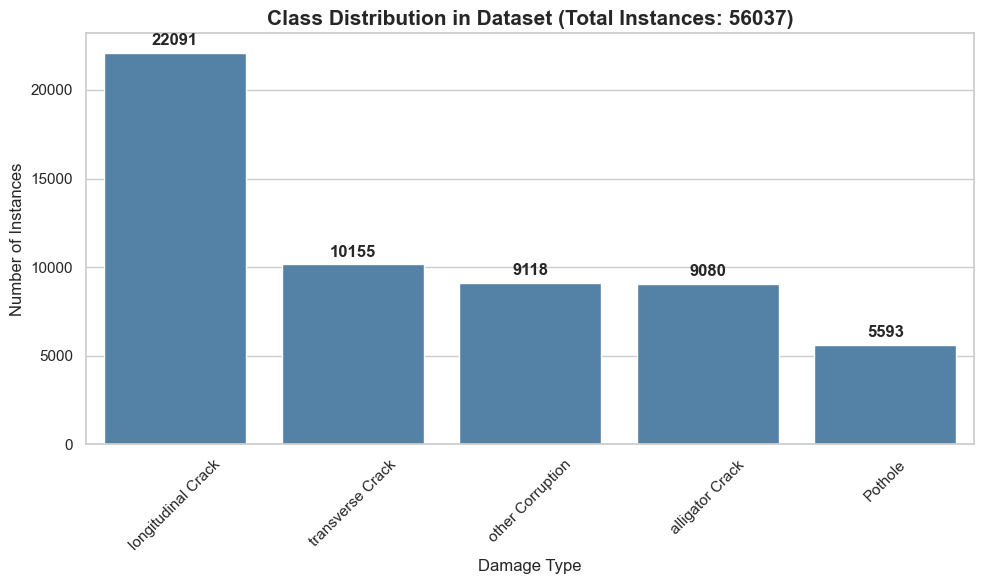

Saved donut chart to: class_distribution_donut.png


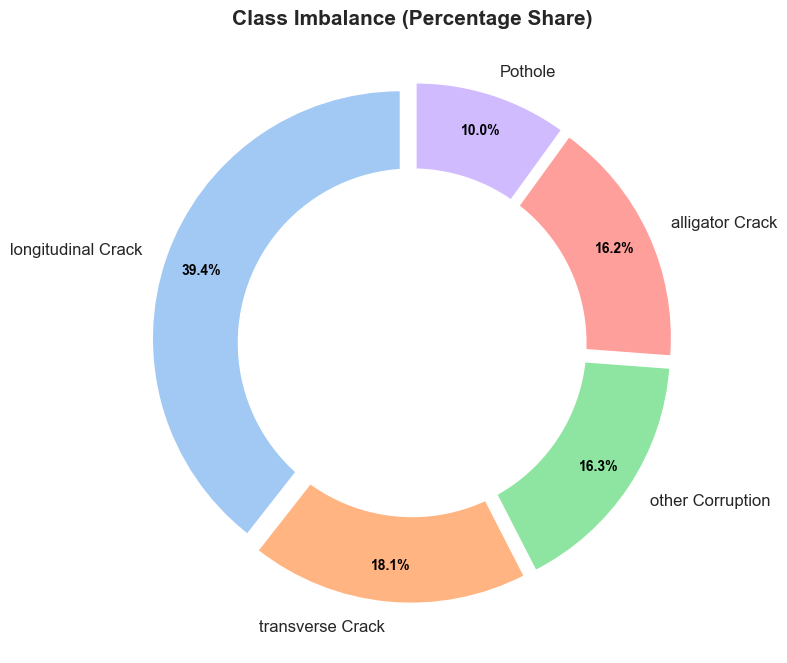

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from collections import Counter

def plot_class_distribution(dataset_path):
    """
    Analyzes label files in a YOLO dataset and plots the class distribution.
    
    Args:
        dataset_path (str): Path to the dataset root folder (containing 'labels/train').
    """
    
    # --- CONFIGURATION ---
    # Update these names to match your dataset.yaml exactly
    CLASS_NAMES = {
        0: 'longitudinal Crack',
        1: 'transverse Crack',
        2: 'alligator Crack',
        3: 'other Corruption',
        4: 'Pothole'
    }
    
    # Define paths to labels (YOLO standard structure)
    base_path = Path(dataset_path)
    train_labels_dir = base_path / 'labels' / 'train'
    val_labels_dir = base_path / 'labels' / 'val'
    
    # Collect all label files
    label_files = []
    if train_labels_dir.exists():
        label_files.extend(list(train_labels_dir.glob('*.txt')))
        print(f"Found {len(list(train_labels_dir.glob('*.txt')))} training label files.")
    else:
        print(f"Warning: Training labels not found at {train_labels_dir}")

    if val_labels_dir.exists():
        label_files.extend(list(val_labels_dir.glob('*.txt')))
        print(f"Found {len(list(val_labels_dir.glob('*.txt')))} validation label files.")
    
    if not label_files:
        print("Error: No label files found. Check your path.")
        return

    # Count classes
    print("Analyzing labels...")
    class_counts = Counter()
    
    for file_path in label_files:
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        class_counts[class_id] += 1
        except Exception as e:
            print(f"Skipping file {file_path}: {e}")

    # Convert to DataFrame for plotting
    data = []
    total_instances = sum(class_counts.values())
    
    for class_id, count in class_counts.items():
        name = CLASS_NAMES.get(class_id, f"Class {class_id}")
        data.append({'Class': name, 'Count': count, 'Percentage': count/total_instances})
    
    df = pd.DataFrame(data)
    # Sort by count for better visualization
    df = df.sort_values('Count', ascending=False)
    
    print("\n--- Class Distribution Summary ---")
    print(df)
    
    # --- PLOT 1: Vertical Bar Chart (Counts) ---
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    
    # Create vertical barplot with a single color
    # Using 'color' instead of 'palette' creates a uniform color
    ax = sns.barplot(x='Class', y='Count', data=df, color='steelblue')
    
    # Add count labels on top of bars
    for i, v in enumerate(df['Count']):
        ax.text(i, v + (max(df['Count'])*0.02), str(v), ha='center', fontweight='bold')
        
    plt.title(f'Class Distribution in Dataset (Total Instances: {total_instances})', fontsize=15, fontweight='bold')
    plt.xlabel('Damage Type')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45) # Rotate labels slightly if they are long
    plt.tight_layout()
    
    # Save plot
    output_bar = 'class_distribution_bar.png'
    plt.savefig(output_bar, dpi=300)
    print(f"\nSaved bar chart to: {output_bar}")
    plt.show()
    
    # --- PLOT 2: Donut Chart (Percentage) ---
    plt.figure(figsize=(8, 8))
    
    # Pie chart
    # We use a muted palette for the pie chart to look professional
    colors = sns.color_palette('pastel', n_colors=len(df))
    
    wedges, texts, autotexts = plt.pie(
        df['Count'], 
        labels=df['Class'], 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors, 
        pctdistance=0.85,
        explode=[0.05]*len(df) 
    )
    
    # Make it a donut
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Style text
    plt.setp(autotexts, size=10, weight="bold", color="black")
    plt.setp(texts, size=12)
    
    plt.title('Class Imbalance (Percentage Share)', fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    output_donut = 'class_distribution_donut.png'
    plt.savefig(output_donut, dpi=300)
    print(f"Saved donut chart to: {output_donut}")
    plt.show()

if __name__ == "__main__":
    # --- UPDATE THIS PATH ---
    # This should point to the folder that contains 'labels/train'
    MY_DATASET_PATH = r"C:\Users\tdngo\road-infra-ng\notebooks\rdd2022_processed" 
    
    # Check if the path has 'labels' inside it, if not, check subfolders
    if not (Path(MY_DATASET_PATH) / 'labels').exists():
        if (Path(MY_DATASET_PATH).parent / 'labels').exists():
             MY_DATASET_PATH = str(Path(MY_DATASET_PATH).parent)
    
    print(f"Scanning dataset at: {MY_DATASET_PATH}")
    plot_class_distribution(MY_DATASET_PATH)